# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

from sklearn.preprocessing import OneHotEncoder


---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df = df[df.columns[1:]] # remove the first column
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
df_analysis = pd.merge(df, diff, on='id')
df_analysis.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


#### Mean price changes over periods

In [7]:
# Calculate the mean difference between consecutive periods
df_analysis['p1_p2_var_mean_diff'] = df_analysis['mean_year_price_p1_var'] - df_analysis['mean_year_price_p2_var']
df_analysis['p2_p3_var_mean_diff'] = df_analysis['mean_year_price_p2_var'] - df_analysis['mean_year_price_p3_var']
df_analysis['p1_p3_var_mean_diff'] = df_analysis['mean_year_price_p1_var'] - df_analysis['mean_year_price_p3_var']
df_analysis['p1_p2_fix_mean_diff'] = df_analysis['mean_year_price_p1_fix'] - df_analysis['mean_year_price_p2_fix']
df_analysis['p2_p3_fix_mean_diff'] = df_analysis['mean_year_price_p2_fix'] - df_analysis['mean_year_price_p3_fix']
df_analysis['p1_p3_fix_mean_diff'] = df_analysis['mean_year_price_p1_fix'] - df_analysis['mean_year_price_p3_fix']

In [8]:
df_analysis.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,p1_p2_var_mean_diff,p2_p3_var_mean_diff,p1_p3_var_mean_diff,p1_p2_fix_mean_diff,p2_p3_fix_mean_diff,p1_p3_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,8.182687,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,16.365274,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


#### Tenure

In [9]:
df_analysis["tenure"] = (
    (df_analysis["date_end"] - df_analysis["date_activ"]) / np.timedelta64(1, "Y")
).astype(int)

df_analysis.groupby(["tenure"]).agg({"churn": "mean"}).sort_values(
    by="churn", ascending=False
)

,churn
tenure,
3,0.143836
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


In [10]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, "M")).astype(int)
    return months

In [11]:
from datetime import datetime

# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df_analysis["months_activ"] = convert_months(reference_date, df_analysis, "date_activ")
df_analysis["months_to_end"] = -convert_months(reference_date, df_analysis, "date_end")
df_analysis["months_modif_prod"] = convert_months(
    reference_date, df_analysis, "date_modif_prod"
)
df_analysis["months_renewal"] = convert_months(
    reference_date, df_analysis, "date_renewal"
)

In [12]:
df_analysis = df_analysis.drop(
    columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"]
)
df_analysis.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,p2_p3_var_mean_diff,p1_p3_var_mean_diff,p1_p2_fix_mean_diff,p2_p3_fix_mean_diff,p1_p3_fix_mean_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.034219,0.058257,18.590255,7.450670,26.040925,3,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.007124,0.149609,44.311375,0.000000,44.311375,7,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.088421,0.170512,44.385450,0.000000,44.385450,6,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,0.151210,44.400265,0.000000,44.400265,6,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.030773,0.051309,16.275263,8.137629,24.412893,6,71,2,71,9


### Transforming numerical data

In [13]:
# log transformations
skewed_features = ['cons_12m', 'cons_gas_12m', 'cons_last_month','forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak']
for item in skewed_features:
    df_analysis[item] = np.log(df_analysis[item] + 1)

In [14]:
df_analysis[skewed_features].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,9.725993,1.793663,5.214898,6.820631,4.109499,0.117128,3.493559,0.128405,0.048164,3.767161
std,2.036741,3.953143,4.073886,1.574076,3.649533,0.615548,1.315902,0.021732,0.046735,0.309103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.643826,0.000000,0.000000,6.206536,0.000000,0.000000,2.843746,0.110055,0.000000,3.728261
50%,9.555135,0.000000,6.677083,7.015362,5.752573,0.000000,2.985682,0.133802,0.080785,3.813558
75%,10.615579,0.000000,8.126814,7.784586,7.465655,0.000000,4.883029,0.136581,0.094252,3.813558
max,15.641205,15.239725,13.555708,11.325437,12.074688,3.433987,6.397446,0.242133,0.178962,4.098774


### Transforming categroical data

In [15]:
# label encoding
df_analysis['has_gas'] = df_analysis['has_gas'].replace({'t': 1, 'f': 0})

In [16]:
df_analysis['channel_sales'].astype('category').value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [17]:
df_analysis = pd.get_dummies(df_analysis, columns=['channel_sales'], prefix='channel_sales')
df_analysis.columns


Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
       'mean_6m_price_p1_var', 'mean_6m_price_p2_var', 'mean_6m_price_p3_var',
       'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix', 'mean_6m_price_p3_fix',
       'mean_6m_price_p1', 'mean_6m_price_p2', 'mean_6m_price_p3',
       'mean_3m_price_p1_var', 'mean_3m_price_p2_var', 'mean_3m_price_p3_var',
       'mean_3m_p

In [18]:
df_analysis = df_analysis.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa'])

In [19]:
df_analysis['origin_up'].astype('category').value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [20]:
df_analysis = pd.get_dummies(df_analysis, columns=['origin_up'], prefix='origin_up')
df_analysis.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'mean_year_price_p1_var',
       'mean_year_price_p2_var', 'mean_year_price_p3_var',
       'mean_year_price_p1_fix', 'mean_year_price_p2_fix',
       'mean_year_price_p3_fix', 'mean_year_price_p1', 'mean_year_price_p2',
       'mean_year_price_p3', 'mean_6m_price_p1_var', 'mean_6m_price_p2_var',
       'mean_6m_price_p3_var', 'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix',
       'mean_6m_price_p3_fix', 'mean_6m_price_p1', 'mean_6m_price_p2',
       'mean_6m_price_p3', 'mean_3m_price_p1_var', 'mean_3m_price_p2_var',
       'mean_3m_price_p3_var', 'mean_3m_price_p1_fix', 'mean_

In [21]:
df_analysis = df_analysis.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])

#### Correlations

C:\Users\ROG\AppData\Local\Temp\ipykernel_6204\56278.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_analysis.corr()


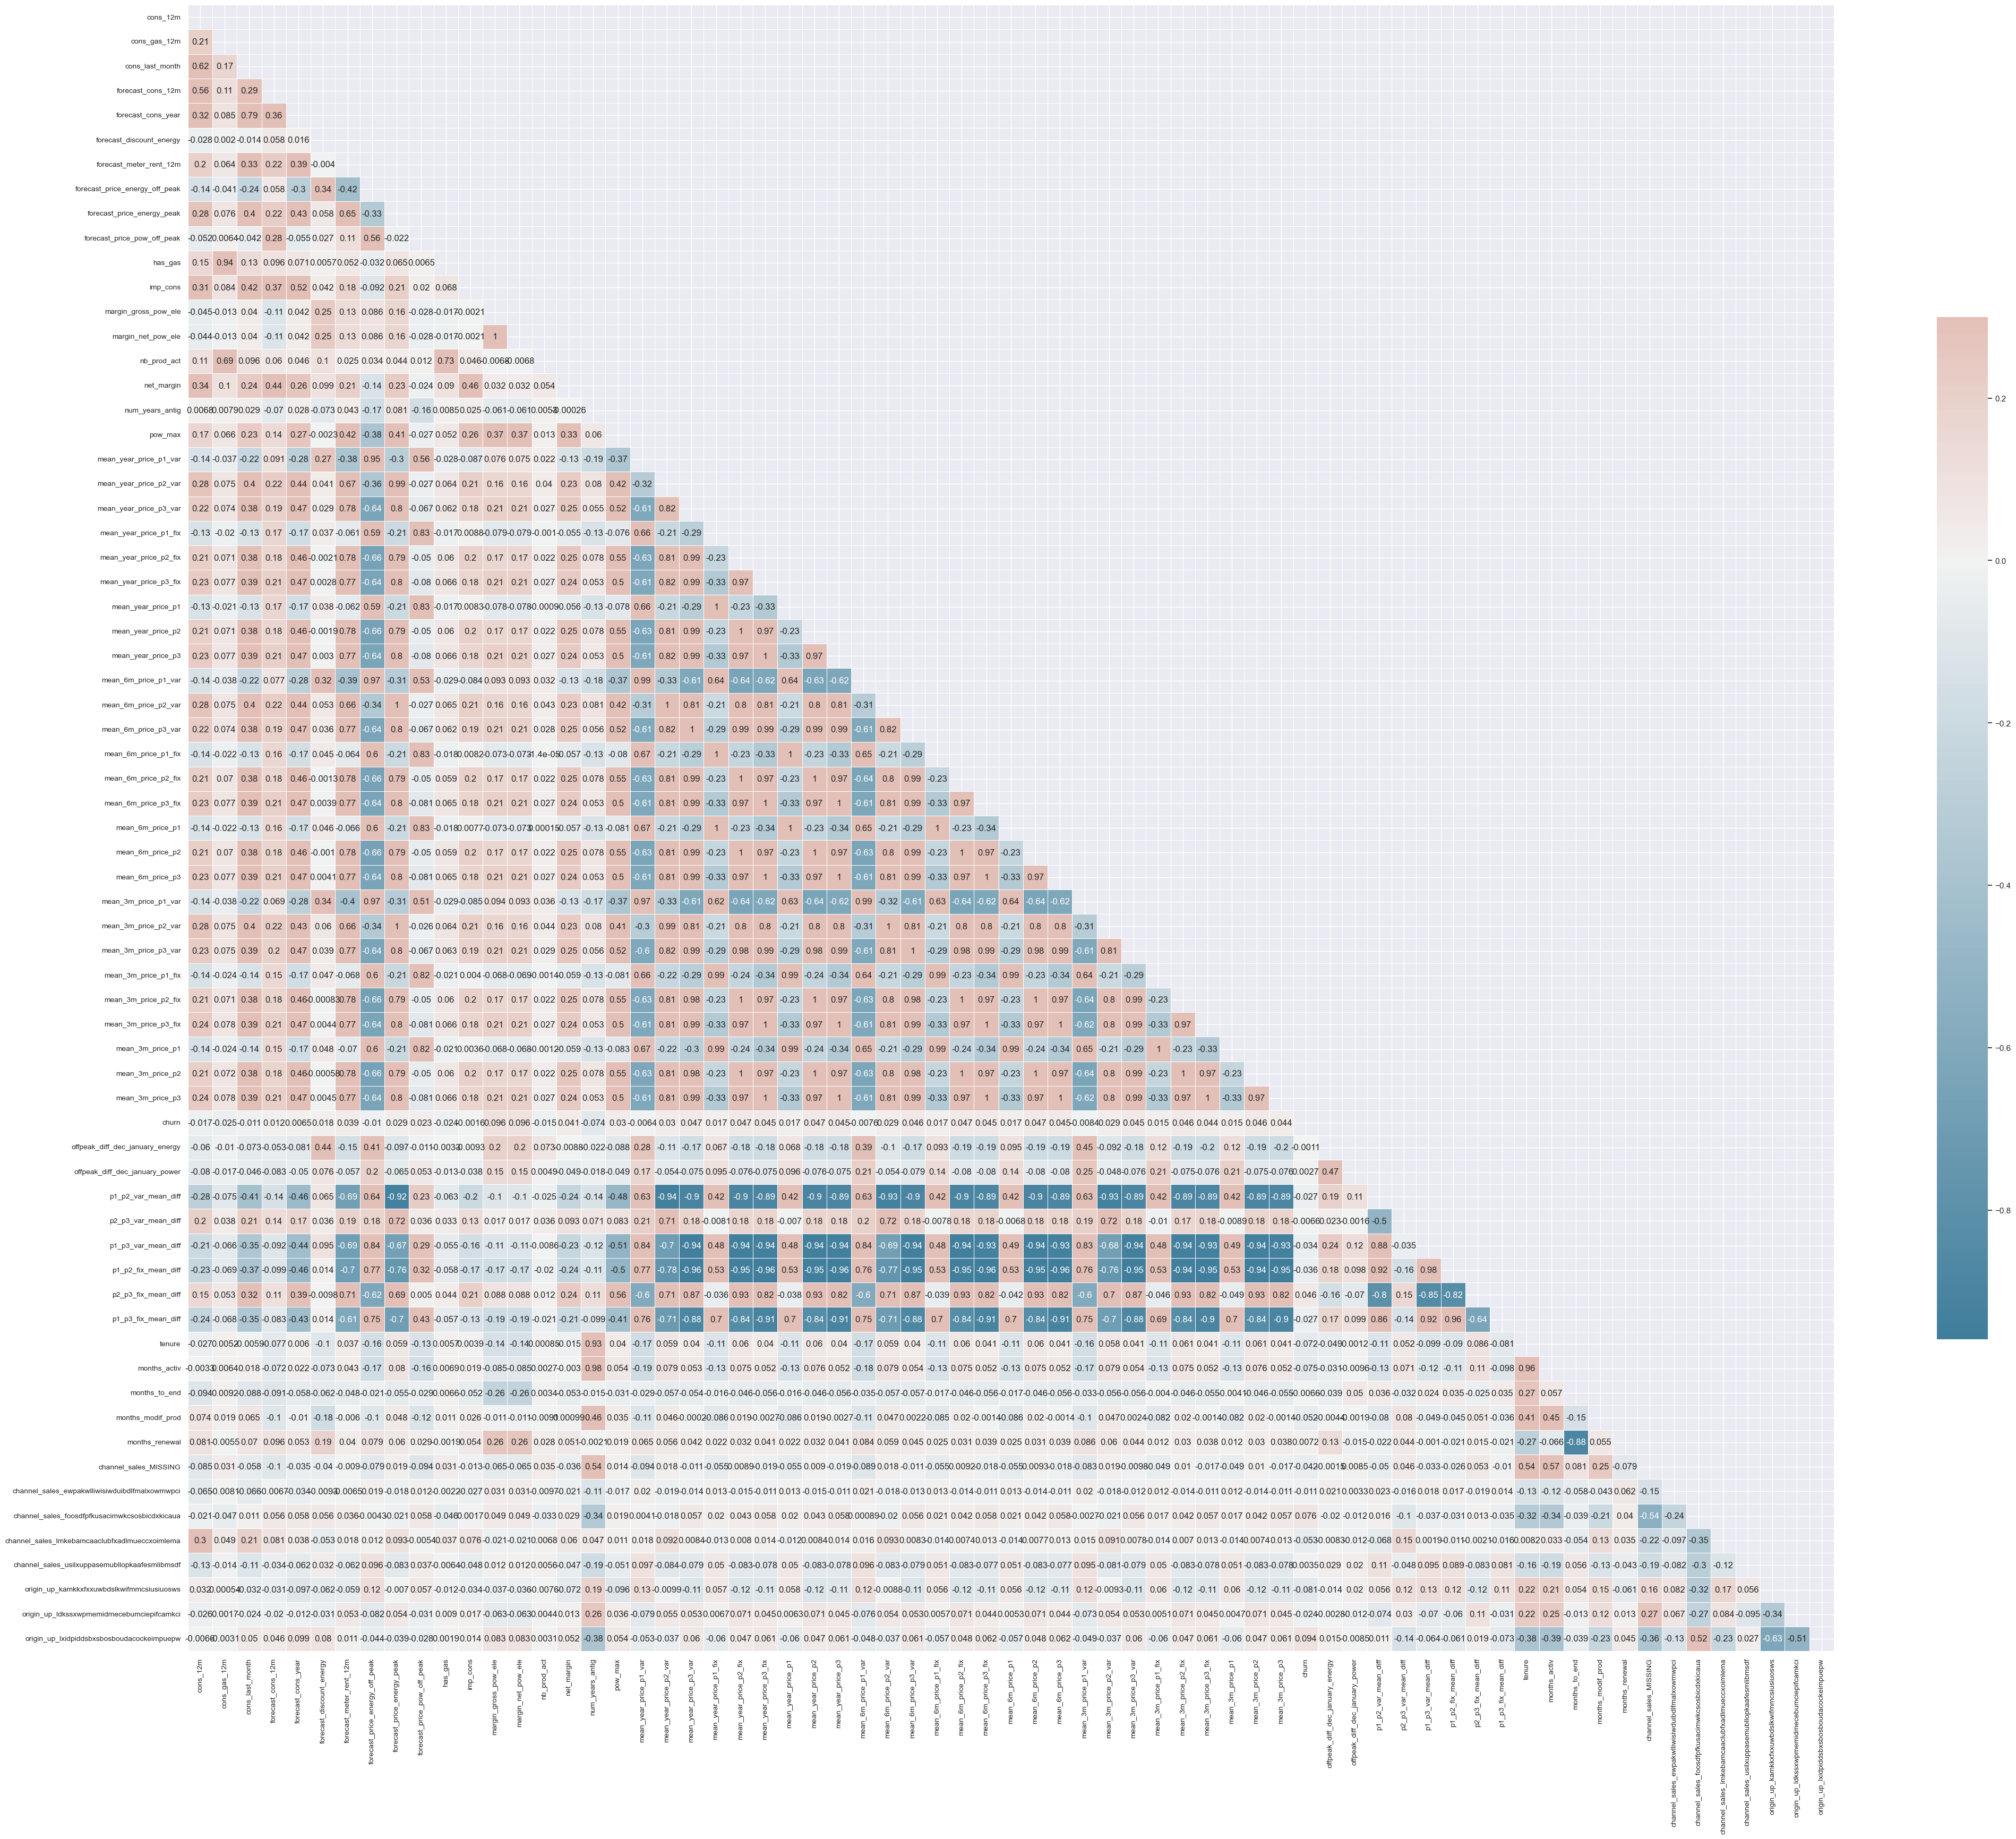

In [22]:
# Compute the correlation matrix
corr = df_analysis.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

##### Varibales selection

In [23]:
df_analysis.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'mean_year_price_p1_var',
       'mean_year_price_p2_var', 'mean_year_price_p3_var',
       'mean_year_price_p1_fix', 'mean_year_price_p2_fix',
       'mean_year_price_p3_fix', 'mean_year_price_p1', 'mean_year_price_p2',
       'mean_year_price_p3', 'mean_6m_price_p1_var', 'mean_6m_price_p2_var',
       'mean_6m_price_p3_var', 'mean_6m_price_p1_fix', 'mean_6m_price_p2_fix',
       'mean_6m_price_p3_fix', 'mean_6m_price_p1', 'mean_6m_price_p2',
       'mean_6m_price_p3', 'mean_3m_price_p1_var', 'mean_3m_price_p2_var',
       'mean_3m_price_p3_var', 'mean_3m_price_p1_fix', 'mean_

In [24]:
df_cleaned = df_analysis.drop(
    columns=[
        "mean_year_price_p1_var",
        "mean_year_price_p2_var",
        "mean_year_price_p3_var",
        "mean_year_price_p2_fix",
        "mean_year_price_p3_fix",
        "mean_year_price_p2",
        "mean_year_price_p3",
        "mean_6m_price_p1_var",
        "mean_6m_price_p2_var",
        "mean_6m_price_p3_var",
        "mean_6m_price_p2_fix",
        "mean_6m_price_p3_fix",
        "mean_6m_price_p1",
        "mean_6m_price_p2",
        "mean_6m_price_p3",
        "mean_3m_price_p1_var",
        "mean_3m_price_p2_var",
        "mean_3m_price_p3_var",
        "mean_3m_price_p2_fix",
        "mean_3m_price_p3_fix",
        "mean_3m_price_p2",
        "mean_3m_price_p3",
        "forecast_cons_year",
        "num_years_antig",
        "channel_sales_MISSING",
        "origin_up_lxidpiddsbxsbosboudacockeimpuepw",
    ]
)
df_cleaned.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_activ,months_to_end,months_modif_prod,months_renewal,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,10.914124,0.000000,0.000000,0.0,1.022451,0.108389,0.093620,3.728261,...,30,5,2,6,0,1,0,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,8.446985,0.000000,0.000000,5.252012,0.0,2.848971,0.136025,0.000000,3.813558,...,76,7,76,4,0,0,0,0,1,0
2,764c75f661154dac3a6c254cd082ea7d,6.300786,0.000000,0.000000,3.891004,0.0,3.681855,0.153402,0.084248,3.813558,...,68,3,68,8,0,1,0,0,1,0
3,bba03439a292a1e166f80264c16191cb,7.368340,0.000000,0.000000,5.484963,0.0,3.036394,0.136883,0.000000,3.813558,...,69,2,69,9,0,0,1,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,8.395252,0.000000,6.267201,6.101999,0.0,4.888317,0.110557,0.095324,3.728261,...,71,2,71,9,0,0,0,0,1,0


## Modelling

In [25]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [26]:
# separate target variable from independent variables
y = df_cleaned["churn"]
X = df_cleaned.drop(columns=["id", "churn"])
print(X.shape)
print(y.shape)

(14605, 40)
(14605,)


In [27]:
# separate data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10953, 40)
(10953,)
(3652, 40)
(3652,)


#### Model traiing and evaluation

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Implementing cross validation

k = 10
kf = KFold(n_splits=k, random_state=None)
model = RandomForestClassifier(n_estimators=1000)

acc_score = []
prec_score = []
recall_score = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    # y_test.value_counts()

    acc = metrics.accuracy_score(y_test, predictions)
    acc_score.append(acc)

    prec = metrics.precision_score(y_test, predictions)
    prec_score.append(prec)

    recall = metrics.recall_score(y_test, predictions)
    recall_score.append(recall)

avg_acc_score = sum(acc_score) / k
avg_prec_score = sum(prec_score) / k
avg_recall_score = sum(recall_score) / k

print("Accuracy of each fold - {}".format(acc_score))
print("Avg accuracy : {}".format(avg_acc_score))

print("Precision of each fold - {}".format(prec_score))
print("Avg precision : {}".format(avg_prec_score))

print("Recall of each fold - {}".format(recall_score))
print("Avg recall : {}".format(avg_recall_score))

Accuracy of each fold - [0.894592744695414, 0.9117043121149897, 0.9034907597535934, 0.9219712525667351, 0.9226557152635181, 0.9027397260273973, 0.9089041095890411, 0.9061643835616439, 0.9034246575342466, 0.9102739726027397]
Avg accuracy : 0.9085921633709318
Precision of each fold - [0.8333333333333334, 0.7058823529411765, 0.9230769230769231, 0.8461538461538461, 0.8125, 1.0, 0.9, 0.9, 0.9, 0.75]
Avg precision : 0.8570946455505281
Recall of each fold - [0.03164556962025317, 0.08823529411764706, 0.07894736842105263, 0.08943089430894309, 0.10569105691056911, 0.0718954248366013, 0.06382978723404255, 0.06206896551724138, 0.06040268456375839, 0.08633093525179857]
Avg recall : 0.07384779807819072


Precision = positive predictive value = proportion of positive examples that are truly positive

Recall = sensitivity = number of true positives / total number of positives



In [29]:
feature_importances = (
    pd.DataFrame(
        {"features": X_train.columns, "importance": model.feature_importances_}
    )
    .sort_values(by="importance", ascending=True)
    .reset_index()
)

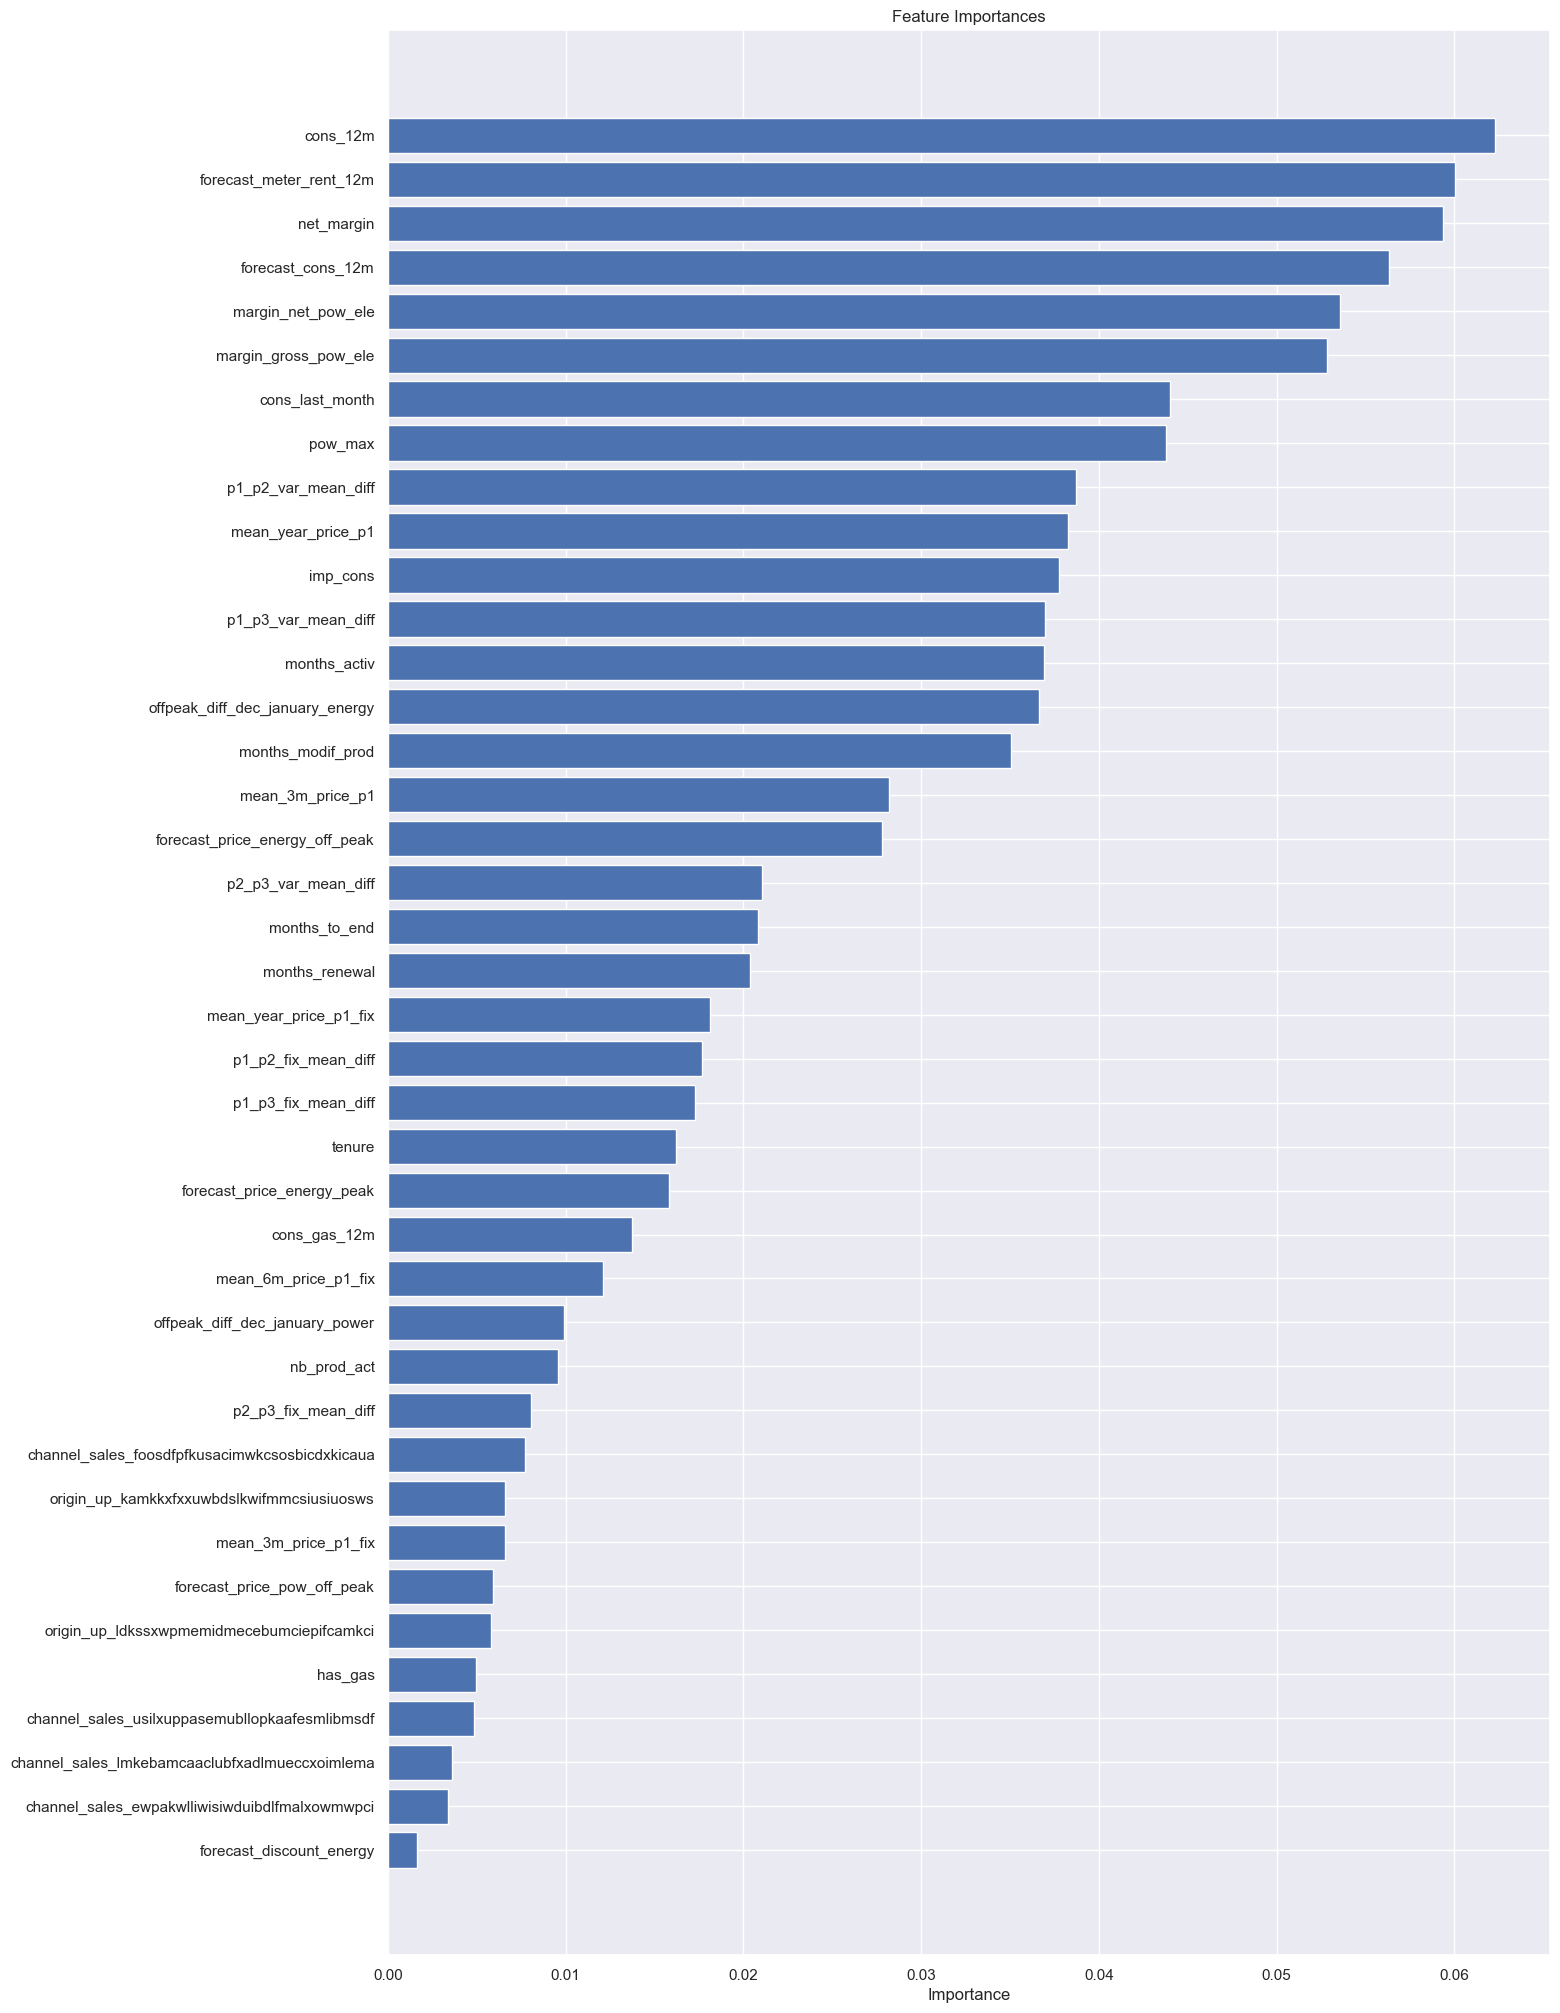

In [30]:
plt.figure(figsize=(15, 25))
plt.title("Feature Importances")
plt.barh(
    range(len(feature_importances)),
    feature_importances["importance"],
    color="b",
    align="center",
)
plt.yticks(range(len(feature_importances)), feature_importances["features"])
plt.xlabel("Importance")
plt.show()